In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from neuron import NeuronParam, SimpleNeuron
from synapse import Synapse
from encoding import RF_convolution, encode, RF_kernel
from parameter import TrainParam
from STDP import stdp, stdp_update

In [2]:
np.random.seed(123)

In [3]:
T = 150
dt = 1
t_past = -20
t_future = 20


n1 = 28*28 # of neurons in layer 1
n2 = 6 # of neurons in layer 2


wmin=-1.2
wmax=2.
tau_past = 10
tau_future = 10
A_past = 0.3
A_future = 0.8

lr = 0.02

train_param = TrainParam(T = T,
                         dt = dt)
    
neuron_param = NeuronParam(t_refractory = 30,
                           V_rest = 0,
                           V_thr = 50,
                           V_min = -5,
                           V_inhibit = -5,
                           leak = 0.75) 

learning_rule = lambda t : stdp(t,
                                tau_past = tau_past, 
                                tau_future = tau_future, 
                                A_past = A_past, 
                                A_future = A_future)

update = lambda w,dw,scale : stdp_update(w,dw,scale,lr,wmin,wmax)

In [4]:
timeline = np.arange(0,T+dt,dt)
layer = [SimpleNeuron(neuron_param) for _ in range(n2)]
synapse = Synapse(n1,layer)
synapse.random_initialize(0,wmax*0.5)

In [5]:
learn = True
n_epoch = 30

for epoch in tqdm(range(n_epoch)):
    for num in range(6):
        winner = -1
        
        image = cv2.imread(f"data/{num}.png",0)
        image = RF_convolution(image,RF_kernel)
        input_spiketrain = encode(image,train_param)
        #adaptation = 1   # No Adaptation
        #adaptation = 18/np.max(np.sum(input_spiketrain,axis=0))  # Adaptation w.r.t. maximum simulatneous activation     
        adaptation = 100/np.sum(image) # Adaptation w.r.t input intensity

        synapse.reset_all_neurons()
        
        output_spiketrain = []
        for timestep,t in enumerate(timeline):
            input_spikes = input_spiketrain[:,timestep] # size = (n1, 1)
            result = synapse.run(input_spikes,
                                 t,
                                 scale = adaptation,
                                 lateral_inhibition = (winner == -1)) # Inhibit Once
                                 #lateral_inhibition = True) # Inhibit Multiple Times 
                                 #lateral_inhibition = False) # No Inhibit
                
            
            
            if not result['winner'] == -1:
                winner = result['winner'] # First firing neuron is winner
                
                
            if learn:
                for out_idx,has_spiked in enumerate(result['output']):
                    if(has_spiked==1): #SPIKE
                        for delta_t in range(-dt-dt,t_past-dt, -dt): #delta_t < 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for in_idx in range(n1):
                                    if input_spiketrain[in_idx,timestep+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[out_idx, in_idx]
                                        assert dw>0
                                        synapse.weight[out_idx, in_idx] = update(w,dw,adaptation) 
                        for delta_t in range(dt+dt,t_future+dt,dt): #delta_t > 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for in_idx in range(n1):
                                    if input_spiketrain[in_idx,timestep+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[out_idx, in_idx]
                                        assert dw<0
                                        synapse.weight[out_idx, in_idx] = update(w,dw,adaptation) 
        
        # Stdp only works when pre/postsynaptic neurons both fire.
        # Therefore no learning can be done if there's no input.
        # As a result, unless given sufficient samples,
        # a single neuron can be activated by multiple numbers.
        # To avoid this phenomena, we reduce synaptic weight of
        # zero-spike pixel to the winner neuron.
        # Therefore, the winner neuron will be less likely to
        # fire when other number has been presented in the future
        if winner != -1:
            input_spike_count = np.sum(input_spiketrain,axis=1) == 0
            zero_spike_inputs = np.nonzero(input_spike_count)[0]
            for i in zero_spike_inputs:
                    synapse.weight[winner,i] = \
                    max(synapse.weight[winner,i]-(0.06*adaptation) , wmin)
 

100%|██████████| 30/30 [00:04<00:00,  7.48it/s]


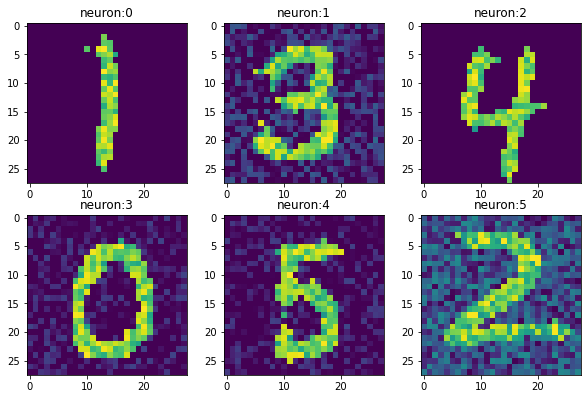

In [6]:
fig = plt.figure(figsize=(10,10))
size = int(np.sqrt(n1))
row = 3
col = n2//row + 1
for num in range(n2):
    plt.subplot(row,col,num+1)
    learned_img = np.interp(synapse.weight[num,:].reshape(size,size),
                            [wmin,wmax],
                            [0,255])
    plt.imshow(learned_img)
    plt.title(f"neuron:{num}")
plt.show()